# A very inaccurate stocks price prediction model

The good old stock prices predicting, the Internet is full of notebooks boasting 90-something accuracy. This one is also pretty good at predicting the prices in part 1. But in part 2, we'll quickly learn that being so accurate in price prediction doesn't mean being successful. We shouldn't be predicting the price at all.

We're going to build the price prediction model with a satisfying accuracy, then we're going to quickly prove that predicting the price is not what we should be after.
This notebook is divided in 2 parts:

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold
from itertools import combinations
from sklearn.feature_selection import SelectKBest, f_classif
import pynance as pn

In [2]:
df = pn.data.get('AAPL', '1980', '2022')

In [3]:
df = df.sort_index()
df = df.reset_index()
df.head()

,Date,Open,High,Low,Close,Volume
0,1984-09-07,0.10135,0.10259,0.10013,0.10135,97112425
1,1984-09-10,0.10135,0.10166,0.09891,0.10075,75375084
2,1984-09-11,0.10166,0.10441,0.10166,0.10259,177738922
3,1984-09-12,0.10259,0.10319,0.09951,0.09951,155270107
4,1984-09-13,0.10503,0.10533,0.10503,0.10503,241827450


In [4]:
df.tail()

,Date,Open,High,Low,Close,Volume
9369,2021-11-08,151.41,151.570,150.1600,150.44,55020868
9370,2021-11-09,150.20,151.428,150.0601,150.81,56787930
9371,2021-11-10,150.02,150.130,147.8500,147.92,65187092
9372,2021-11-11,148.96,149.430,147.6810,147.87,40999950
9373,2021-11-12,148.43,150.400,147.4800,149.99,63804008


In [5]:
df['last5'] = df['Close'].shift(1).rolling(window=5).mean()
df['last30'] = df['Close'].shift(1).rolling(window=30).mean()
df['vol5'] = df['Volume'].shift(1).rolling(window=5).mean()
df['vol30'] = df['Volume'].shift(1).rolling(window=30).mean()

df['change'] = df['Close'] - df['Close'].shift()
df['dev'] = df['High'] - df['Low']
df['prev_close'] = df['Close'].shift()
df['prev_volume'] = df['Volume'].shift()
df['prev_change'] = df['change'].shift()
df['prev_dev'] = df['dev'].shift()
df['prev_low'] = df['Low'].shift()
df['prev_high'] = df['High'].shift()
df['change_5'] = df['change'].shift(1).rolling(window=5).mean()
df['change_30'] = df['change'].shift(1).rolling(window=30).mean()
df['prev_power'] =   df['prev_change'] * df['prev_volume']
df['dir'] = np.where(df['prev_change']>=0, 1,0)
df['prev_dir'] = df['dir'].shift()
df = df[df['Date']> '1984-10-20']

In [6]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'last5', 'last30',
       'vol5', 'vol30', 'change', 'dev', 'prev_close', 'prev_volume',
       'prev_change', 'prev_dev', 'prev_low', 'prev_high', 'change_5',
       'change_30', 'prev_power', 'abs_change'],
      dtype='object')

In [7]:
def spines(ax,yl='price',xl='date'):
    x1 = ax.spines['right'].set_visible(False)
    x2 = ax.spines['top'].set_visible(False)
    x3 = ax.spines['left'].set_linewidth(2)
    x4 = ax.spines['bottom'].set_linewidth(2)
    x5 = ax.set_ylabel(yl)
    x6 = ax.set_xlabel(xl)
    return x1, x2, x3, x4, x5, x6

In [8]:
def train_and_test1(df, features):
    # split
    train = df[df['Date'] < '2021-01-01']
    test = df[df['Date'] >= '2021-01-01']

    # train
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train["Close"])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test["Close"], predictions)
    rmse = np.sqrt(mse)
    
    return rmse, predictions

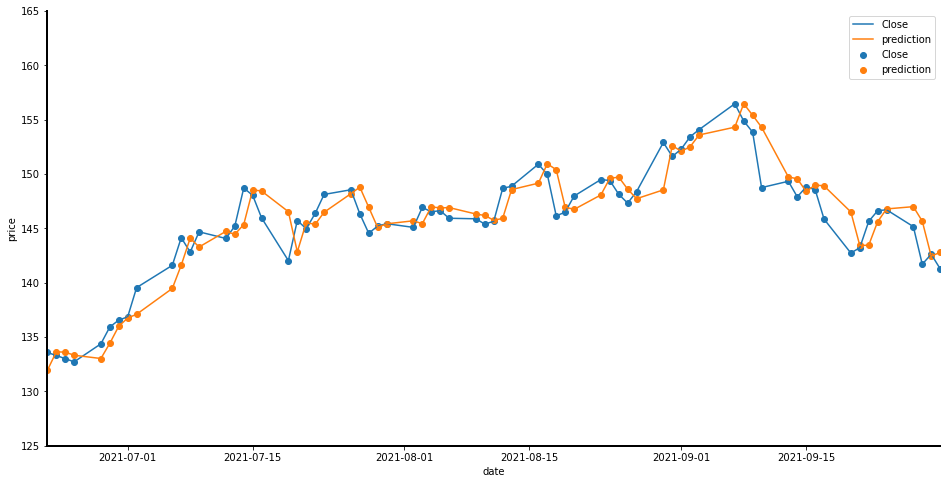

In [9]:
r,p = train_and_test1(df, ['prev_close','prev_change'])
results = df[['Date', 'Close', 'change']].copy()
results = results[results['Date']>= '2021-01-01'].copy()
results['predicted'] = p
fig, ax = plt.subplots(figsize=(16,8))
plt.scatter(results['Date'], results['Close'], label='Close')
plt.plot(results['Date'], results['Close'], label='Close')
plt.scatter(results['Date'], results['predicted'], label='prediction')
plt.plot(results['Date'], results['predicted'], label='prediction')
plt.legend()
spines(ax)
plt.xlim(18800,18900)
plt.ylim(125,165)
plt.show()


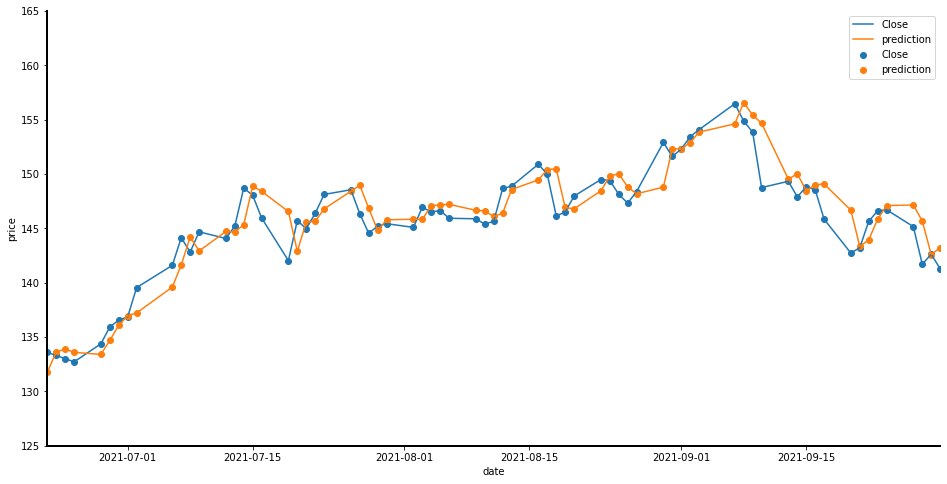

In [10]:
r,p = train_and_test1(df, ['prev_change', 'last5', 'last30',
       'vol5', 'vol30', 'prev_close', 'prev_volume',
       'prev_change', 'prev_dev', 'prev_low', 'prev_high', 'prev_power'])
results = df[['Date', 'Close', 'change']].copy()
results = results[results['Date']>= '2021-01-01'].copy()
results['predicted'] = p
fig, ax = plt.subplots(figsize=(16,8))
plt.scatter(results['Date'], results['Close'], label='Close')
plt.plot(results['Date'], results['Close'], label='Close')
plt.scatter(results['Date'], results['predicted'], label='prediction')
plt.plot(results['Date'], results['predicted'], label='prediction')
plt.legend()
spines(ax)
plt.xlim(18800,18900)
plt.ylim(125,165)
plt.show()



In [11]:
def train_and_test2(df, features):
    # split
    train = df[df['Date'] < '2021-01-01']
    test = df[df['Date'] >= '2021-01-01']

    # train
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train["change"])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test["change"], predictions)
    rmse = np.sqrt(mse)
    
    return rmse, predictions

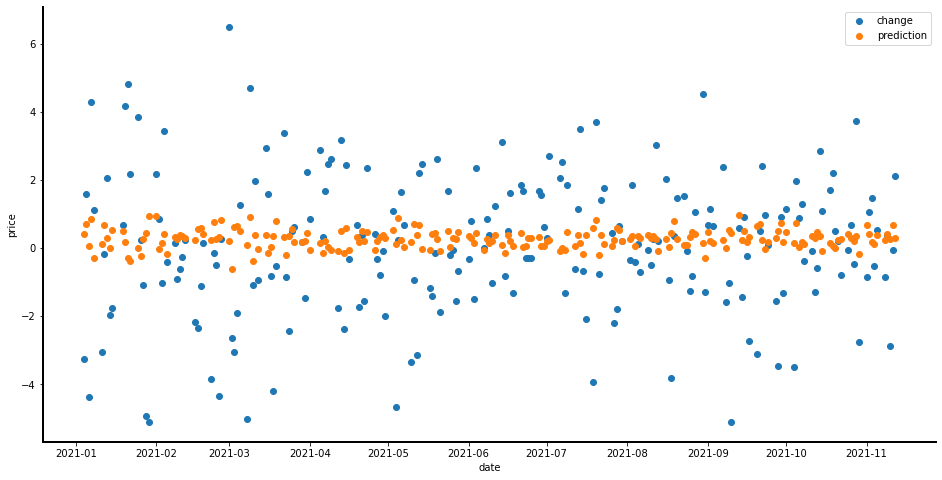

In [12]:
def plot_it(df, features):
    results = df[['Date', 'Close', 'change']].copy()
    r,p = train_and_test2(df, features)
    results = results[results['Date']>= '2021-01-01'].copy()
    results['predicted'] = p
    fig, ax = plt.subplots(figsize=(16,8))
    x1 = plt.scatter(results['Date'], results['change'], label='change')
    x2 = plt.scatter(results['Date'], results['predicted'], label='prediction')
    x3 = plt.legend()
    x4 = spines(ax)
    return fig, ax, x1, x2, x3, x4, results

fig, ax, x1, x2, x3, x4, results = plot_it(df, ['prev_close','prev_change', 'prev_volume'])
fig, ax, x1, x2, x3, x4
plt.show()

In [13]:
results['dir'] = ((results['change'] > 0) & (results['predicted'] > 0)) |  ((results['change'] < 0) & (results['predicted'] < 0))
results['dir'].value_counts(normalize=True)

True     0.520548
False    0.479452
Name: dir, dtype: float64

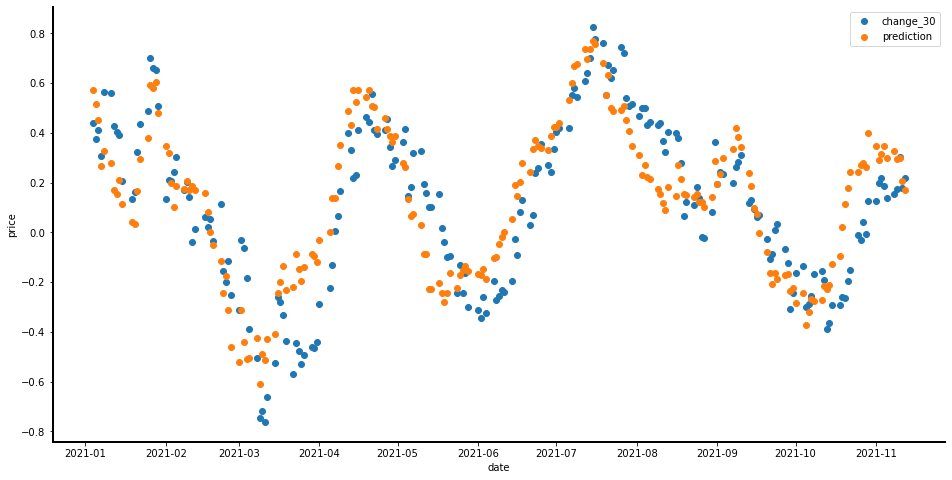

In [20]:

def train_and_test3(df, features):
    # split
    train = df[df['Date'] < '2021-01-01']
    test = df[df['Date'] >= '2021-01-01']

    # train
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train["change_30"])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test["change_30"], predictions)
    rmse = np.sqrt(mse)
    
    return rmse, predictions

def plot_it2(df, features):
    results = df[['Date', 'Close', 'change', 'change_30']].copy()
    r,p = train_and_test3(df, features)
    results = results[results['Date']>= '2021-01-01'].copy()
    results['predicted'] = p
    fig, ax = plt.subplots(figsize=(16,8))
    x1 = plt.scatter(results['Date'], results['change_30'], label='change_30')
    x2 = plt.scatter(results['Date'], results['predicted'], label='prediction')
    x3 = plt.legend()
    x4 = spines(ax)
    return fig, ax, x1, x2, x3, x4, results

fig, ax, x1, x2, x3, x4, results = plot_it2(df, ['last5', 'last30',
       'vol5', 'vol30', 'prev_close', 'prev_volume',
        'prev_dev', 'prev_low', 'prev_high', 
       'prev_power'])
fig, ax, x1, x2, x3, x4
plt.show()

In [16]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'last5', 'last30',
       'vol5', 'vol30', 'change', 'dev', 'prev_close', 'prev_volume',
       'prev_change', 'prev_dev', 'prev_low', 'prev_high', 'change_5',
       'change_30', 'prev_power', 'abs_change'],
      dtype='object')

In [ ]:

fig, ax, x1, x2, x3, x4, results = plot_it(df, ['prev_power', 'last5', 
         'prev_close', 'prev_volume',
       'prev_change', 'prev_dev', 'abs_change'])
fig, ax, x1, x2, x3, x4
plt.show()

In [ ]:
results['dir'] = ((results['change'] > 0) & (results['predicted'] > 0)) |  ((results['change'] < 0) & (results['predicted'] < 0))
results['dir'].value_counts(normalize=True)

In [ ]:
date_col =  df['Date']
change_col = df['change']
df_n = (df - df.min())/(df.max() - df.min()).copy()
df_n['change'] = change_col
df_n['Date'] = date_col
fig, ax, x1, x2, x3, x4, results = plot_it(df_n,['prev_power', 'last5', 
         'prev_close', 'prev_volume',
       'prev_change', 'prev_dev', ])
fig, ax, x1, x2, x3, x4
plt.show()

In [ ]:
results['dir'] = ((results['change'] > 0) & (results['predicted'] > 0)) |  ((results['change'] < 0) & (results['predicted'] < 0))
results['dir'].value_counts(normalize=True)

In [ ]:
df_2010 = df[df['Date'] > '2015-01-01'].copy()
df_2010.head()

In [ ]:
fig, ax, x1, x2, x3, x4, results = plot_it(df_2010,['prev_power', 'last5', 
         'prev_close', 'prev_volume',
       'prev_change', 'prev_dev', ])
fig, ax, x1, x2, x3, x4
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(df['Date'], abs(df['change']))
plt.show()

In [ ]:
def train_and_test3(df, features):
    # split
    train = df[df['Date'] < '2021-01-01']
    test = df[df['Date'] >= '2021-01-01']

    # train
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train["abs_change"])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test["abs_change"], predictions)
    rmse = np.sqrt(mse)
    
    return rmse, predictions

In [ ]:
r,p = train_and_test3(df_2010, ['last5', 'last30',
       'vol5', 'vol30', 'prev_close', 'prev_volume',
       'prev_change', 'prev_dev', 'prev_low', 'prev_high', 'prev_power',
       'prev_day_dev'])
r

In [ ]:
df['prev_day_dev'] = (df['High'].shift(1) - df['Low'].shift(1)) / df['Close'].shift(1) *100
df2 = df[df['Date'] > '1951-07-01'].copy()

In [ ]:
df2.columns

In [ ]:
def spines(ax,yl='price',xl='date'):
    x1 = ax.spines['right'].set_visible(False)
    x2 = ax.spines['top'].set_visible(False)
    x3 = ax.spines['left'].set_linewidth(2)
    x4 = ax.spines['bottom'].set_linewidth(2)
    x5 = ax.set_ylabel(yl)
    x6 = ax.set_xlabel(xl)
    return x1, x2, x3, x4, x5, x6

In [ ]:
rmse, results = train_and_test2(df2, ['last5'])
results_frame = df2[df2['Date'] >= '2013-01-01'][['Date','Close']].copy()
results_frame['results'] = results
fig, ax = plt.subplots(figsize=(16,8))
# plt.scatter(results_frame['Date'], results_frame['results'])
plt.plot(results_frame['Date'], results_frame['results'],linewidth=2 , label='predictions')
plt.plot(results_frame['Date'], results_frame['Close'],linewidth=2, label='real prices')
spines(ax)
plt.legend()
plt.title('Stock prices vs predictions')
plt.show()

In [ ]:
rmse, results = train_and_test2(df2, [ 'last30', 'last365'])
results_frame = df2[df2['Date'] >= '2013-01-01'][['Date','Close']].copy()
results_frame['results'] = results
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(results_frame['Date'], results_frame['results'],linewidth=2 , label='predictions')
plt.plot(results_frame['Date'], results_frame['Close'],linewidth=2, label='real prices')
spines(ax)
plt.legend()
plt.title('Stock prices vs predictions')
plt.show()

In [ ]:
results_frame = results_frame[1:].copy()

In [ ]:
results_frame = df2[df2['Date'] >= '2013-01-01'][['Date','Close']].copy()
results_frame['results'] = results
results_frame = results_frame[1:].copy()
frame2 = results_frame[results_frame['Date']>'2015-08-12']

fig, ax = plt.subplots(figsize=(16,8))
plt.plot(frame2['Date'], frame2['Close'],linewidth=2, label='real prices')
plt.scatter(frame2['Date'], frame2['Close'], label='real prices')
plt.plot(frame2['Date'], frame2['results'],linewidth=2 , label='predictions')
plt.scatter(frame2['Date'], frame2['results'], label='predictions')
spines(ax)
plt.legend()
plt.title('Stock prices vs predictions')
plt.show()

In [ ]:
results_frame['up_or_down'] = results_frame['Close'] - results_frame['Close'].shift()
results_frame['predict_up_or_down'] = results_frame['results'] - results_frame['Close'].shift()
results_frame['true_results'] = (results_frame['up_or_down'] > 0) == (results_frame['predict_up_or_down'] > 0)
results_frame['true_results'].value_counts(normalize=True)

In [ ]:
abs(results_frame['predict_up_or_down']).mean()

In [ ]:
abs(results_frame['up_or_down']).mean()

Lets introduce some previous day data:
* the volume of trading on a previous day
* close price
* 'prev_day_magnify' in this column we'll multiply 'prev_day_close' by 'prev_day_vol' (it should strongly indicate the direction of the market)

In [ ]:
df['prev_day_vol'] = df['Volume'].shift(1)
df['prev_day_close'] = df['Close'].shift(1)
df['prev_day_magnify'] = df['prev_day_vol'] * df['prev_day_dev']
df2 = df[df['Date'] > '1951-07-01'].copy()
res = train_and_test2(df2, ['last5', 'last30', 'last365', 'vol5', 'vol30', 'vol365', 'prev_day_dev',
                     'prev_day_vol','prev_day_close', 'prev_day_magnify'])

In [ ]:
df['prev_day_open'] = df['Open'].shift(1)
df['prev_day_low'] = df['Low'].shift(1)
df['prev_day_high'] = df['High'].shift(1)
df2 = df[df['Date'] > '1951-07-01'].copy()
df2.columns

In [ ]:
features2 = ['last5','last30', 'last365', 'vol5', 'vol30', 'vol365', 'prev_day_dev',
       'prev_day_vol', 'prev_day_close', 'prev_day_magnify', 'prev_day_open',
       'prev_day_low', 'prev_day_high']
rmse, results = train_and_test2(df2, features2)
rmse

In [ ]:

results_frame = df2[df2['Date'] >= '2013-01-01'][['Date','Close']].copy()
results_frame['results'] = results
results_frame = results_frame[1:].copy()
frame2 = results_frame[results_frame['Date']>'2015-08-12']

fig, ax = plt.subplots(figsize=(16,8))

plt.plot(frame2['Date'], frame2['Close'],linewidth=2, label='real prices')
plt.scatter(frame2['Date'], frame2['Close'], label='real prices')
plt.plot(frame2['Date'], frame2['results'],linewidth=2 , label='predictions')
plt.scatter(frame2['Date'], frame2['results'], label='predictions')
spines(ax)
plt.legend()
plt.title('Stock prices vs predictions')
plt.show()

In [ ]:
results_frame['up_or_down'] = results_frame['Close'] - results_frame['Close'].shift()
results_frame['predict_up_or_down'] = results_frame['results'] - results_frame['Close'].shift()
results_frame['true_results'] = (results_frame['up_or_down'] > 0) == (results_frame['predict_up_or_down'] > 0)
results_frame['true_results'].value_counts(normalize=True)

In [ ]:
df['prev_day_dev'].describe()

In [ ]:
df[df['prev_day_dev'] > 5]

# but wait a second! lets train the model to predict the movement not the price!

In [ ]:
df2['up_or_down'] = df2['Close'].shift(2) - df2['Close'].shift(1)
df2[["Close",'up_or_down']][:10]
df2 = df2[2:]

In [ ]:
def train_and_test3(df, features):
    # split 50:50
    train = df2[df2['Date'] < '2013-01-01']
    test = df2[df2['Date'] >= '2013-01-01']

    # train
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train["up_or_down"])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test["up_or_down"], predictions)
    rmse = np.sqrt(mse)
    
    return rmse, predictions

In [ ]:
features2 = ['last5','last30', 'last365', 'vol5', 'vol30', 'vol365', 'prev_day_dev',
       'prev_day_vol', 'prev_day_close', 'prev_day_magnify', 'prev_day_open',
       'prev_day_low', 'prev_day_high']
rmse, results = train_and_test3(df2, features2)
rmse

In [ ]:
rmse /df2["up_or_down"].mean()

In [ ]:
res_frame2 = df2[df2['Date'] >= '2013-01-01'] .copy()
res_frame2.loc[res_frame2['Date'] >= '2013-01-01','predicted']= results
res_frame2['true_results'] = (res_frame2['up_or_down'] > 0) == (res_frame2['predicted'] > 0)
res_frame2['true_results'].value_counts(normalize=True)
# res_frame2[['up_or_down','predicted' ]]

In [ ]:
res_frame2['Close2'] = res_frame2['Close'].shift(1) + res_frame2['predicted'].shift(1)
res_frame2

In [ ]:

fig, ax = plt.subplots(figsize=(16,98))

plt.plot( res_frame2['up_or_down'],res_frame2['Date'],linewidth=2, label='real prices')
plt.scatter(res_frame2['up_or_down'],res_frame2['Date'],  label='real prices')
plt.plot( res_frame2['predicted'],res_frame2['Date'],linewidth=2 , label='predictions')
plt.scatter( res_frame2['predicted'],res_frame2['Date'], label='predictions')
spines(ax)
plt.legend()
plt.title('Stock prices vs predictions')
# plt.xlim(16200,16290)
plt.show()

In [ ]:
res_frame3 = res_frame2[1:]

In [ ]:
mse = mean_squared_error( res_frame3['Close'], res_frame3['Close2'])
rmse = np.sqrt(mse)
rmse

In [ ]:

fig, ax = plt.subplots(figsize=(16,8))

res_frame3 = res_frame3[res_frame3['Date']>'2015-07-01']


plt.plot(res_frame3['Date'], res_frame3['Close'],linewidth=2, label='real prices')
plt.scatter(res_frame3['Date'], res_frame3['Close'], label='real prices')
plt.plot(res_frame3['Date'], res_frame3['Close2'],linewidth=2 , label='predictions')
plt.scatter(res_frame3['Date'], res_frame3['Close2'], label='predictions')
spines(ax)
plt.legend()
plt.title('Stock prices vs predictions')
plt.show()

In [ ]:
res_frame3[['Date','Close','predicted','up_or_down','Close2']]